# Step 0 -- get the data

In [1]:
!wget https://d17h27t6h515a5.cloudfront.net/topher/2016/December/584f6edd_data/data.zip -O data.zip

--2016-12-27 10:35:04--  https://d17h27t6h515a5.cloudfront.net/topher/2016/December/584f6edd_data/data.zip
Resolving d17h27t6h515a5.cloudfront.net (d17h27t6h515a5.cloudfront.net)... 54.230.216.219, 54.230.216.170, 54.230.216.189, ...
Connecting to d17h27t6h515a5.cloudfront.net (d17h27t6h515a5.cloudfront.net)|54.230.216.219|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 333137665 (318M) [application/zip]
Saving to: 'data.zip'

100%[======================================>] 333,137,665 20.9MB/s   in 19s    

2016-12-27 10:35:23 (16.6 MB/s) - 'data.zip' saved [333137665/333137665]



In [2]:
!unzip -q data.zip
!mv data udacity_data
!rm -rf __MACOSX/

In [1]:
DATA_FOLDER = 'udacity_data/'

# Step 1 -- data generator

In [2]:
import pandas as pd
import numpy as np
import cv2

import matplotlib.pyplot as plt
import seaborn
%matplotlib inline

In [3]:
log = pd.read_csv(DATA_FOLDER + 'driving_log.csv')

In [4]:
log.steering.describe()

count    8036.000000
mean        0.004070
std         0.128840
min        -0.942695
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: steering, dtype: float64

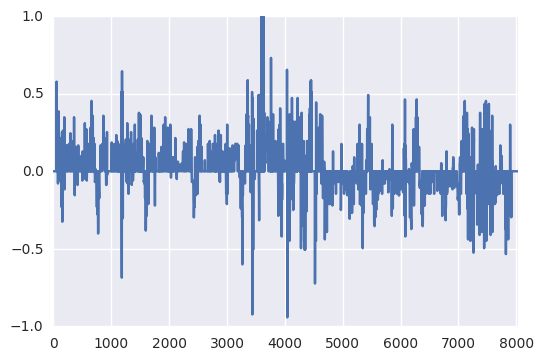

In [5]:
log.steering.plot()

In [6]:
input_shape = (40, 160, 3)

In [7]:
# Input images must be RGB!
def image_transformation(img):
    img = img[60:-20,:,:]
    img = cv2.resize(img, (input_shape[1], input_shape[0]), interpolation=cv2.INTER_AREA)
    return img

In [8]:
def data_generator(data, batch_size):
    while True:
        X = np.zeros((batch_size, *input_shape), dtype=np.float32)
        y = np.zeros((batch_size,), dtype=np.float32)
        for idx in range(batch_size):
            row = data.sample()
            img = cv2.imread(DATA_FOLDER + row.center.values[0])
            X[idx] = image_transformation(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) # Keep RGB input
            y[idx] = row.steering.values[0]
        yield X, y

(-0.5, 159.5, 39.5, -0.5)

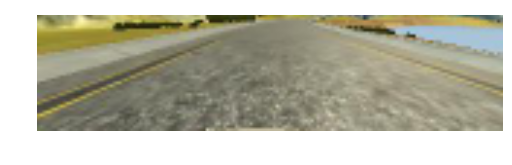

In [9]:
row = log.sample(1)
img = cv2.imread(DATA_FOLDER + row.center.values[0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = image_transformation(img)
plt.imshow(img)
plt.axis('off')

# Step 2 -- define the model

In [10]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, ELU, Lambda
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


Big thanks to [Vivek Yadav](https://github.com/vxy10/P3-BehaviorCloning) for sharing his architecture!

In [11]:
def get_vivek_model():
    model = Sequential()
    model.add(Lambda(lambda x: x/127.5 - 1., input_shape=input_shape))
    model.add(Convolution2D(3,1,1,  border_mode='valid', name='conv0', init='he_normal'))
    model.add(Convolution2D(32,3,3, border_mode='valid', name='conv1', init='he_normal'))
    model.add(ELU())
    model.add(Convolution2D(32,3,3, border_mode='valid', name='conv2', init='he_normal'))
    model.add(ELU())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.5))
    
    model.add(Convolution2D(64,3,3, border_mode='valid', name='conv3', init='he_normal'))
    model.add(ELU())
    model.add(Convolution2D(64,3,3, border_mode='valid', name='conv4', init='he_normal'))
    model.add(ELU())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.5))
    
    model.add(Convolution2D(128,3,3, border_mode='valid', name='conv5', init='he_normal'))
    model.add(ELU())
    model.add(Convolution2D(128,3,3, border_mode='valid', name='conv6', init='he_normal'))
    model.add(ELU())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.5))
    
    model.add(Flatten())
    model.add(Dense(512,name='hidden1', init='he_normal'))
    model.add(ELU())
    model.add(Dropout(0.5))
    model.add(Dense(64,name='hidden2', init='he_normal'))
    model.add(ELU())
    model.add(Dropout(0.5))
    model.add(Dense(16,name='hidden3',init='he_normal'))
    model.add(ELU())
    model.add(Dropout(0.5))
    model.add(Dense(1, name='output', init='he_normal'))
    model.compile(optimizer="adam", loss="mse")
    return model

In [12]:
model = get_vivek_model()
model.fit_generator(
    data_generator(log, 100),
    samples_per_epoch=8000,
    nb_epoch=30
)

Epoch 1/30
8000/8000 [==============================] - 13s - loss: 0.0149      

In [13]:
import json
with open('model.json', 'w') as f:
    f.write(model.to_json())
model.save_weights('model.h5')